In [58]:
%load_ext autoreload
%autoreload
%matplotlib inline
import pandas as pd
import warnings
#from sklearn.exceptions import UndefinedMetricWarning
#warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC #, SVC
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
#import itertools
#import math
from matplotlib import style
style.use('seaborn-dark')
sns.set_color_codes()

import tl_learning as tl
import sys
sys.path.append('../')
import support_utils as sup
import tl_utils as tlut
import data_explore_utils as dex

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Recommended NBExtensions:**
- Collapsible Headings
- Table_beautifier

In [59]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',100)

### Import Candsets

In [60]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})'
sep = ','
# ***********************************************

candsets = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [61]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})_train'
sep = ','
# ***********************************************

candsets_train = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [62]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_feature_(.{2,4}_.{2,4})_test'
sep = ','
# ***********************************************

candsets_test = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [63]:
# see DocString of readDataInDictionary() function for information

# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../candsets/authors/'
pattern_of_filename = 'candset_(.{2,4}_.{2,4})'
sep = ','
# ***********************************************

candsets_org_attr = sup.readDataInDictionary(path_to_directory,pattern_of_filename,sep)

In [64]:
candsets.keys()

dict_keys(['dbp_dnb', 'dbp_wiki', 'dbp_viaf'])

### Feature Sets and Setup

In [65]:
all_feature = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'work_cosine_tfidf_sim', 'work_lev_sim',
       'work_jac_q3_sim', 'work_jac_an_sim', 'work_rel_jac_an_sim',
       'work_containment_sim', 'work_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

In [66]:
len(all_feature) == len(candsets['dbp_dnb'].columns.drop(['ids','label']))

True

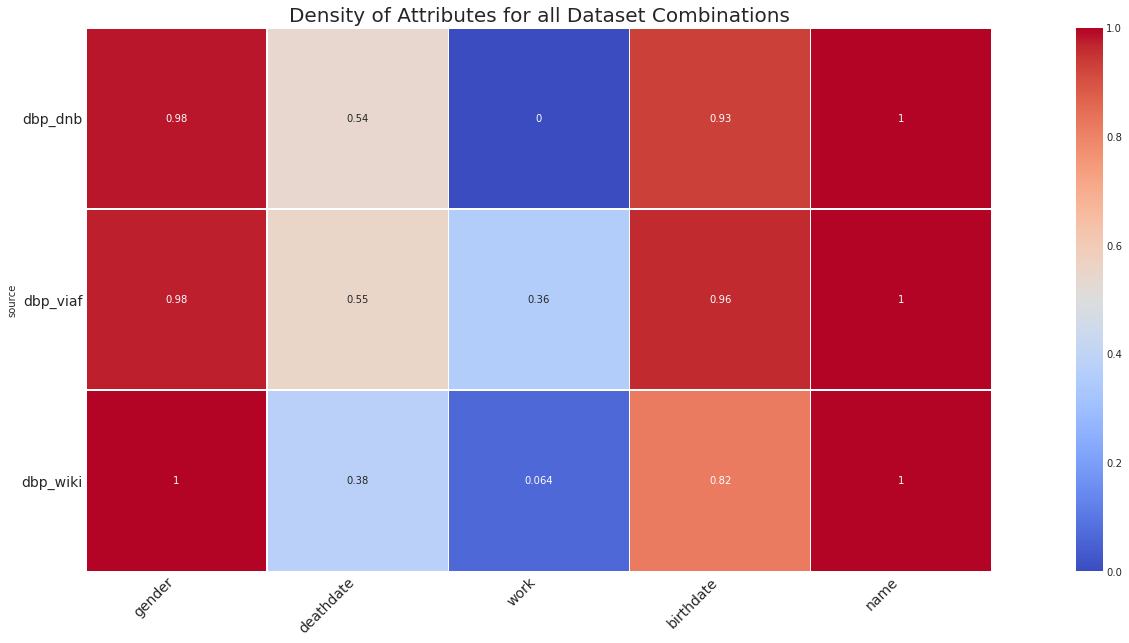

In [67]:
dex.plotDensityAttributesHeatmap(candsets)

In [68]:
# dense features for all combinations

# features excluded where the attribute has a very low density (<3%) for at 
# least one dataset that is involved either as source or target in the TL setting
rc_dbp_viaf_wiki = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

rc_dbp_dnb_wiki = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

rc_dbp_dnb_viaf = ['deathdate_days_diff_sim', 'deathdate_months_diff_sim',
       'deathdate_years_diff_sim', 'gender_lev_sim', 'gender_jac_q3_sim',
       'gender_jac_an_sim', 'gender_rel_jac_an_sim', 'gender_containment_sim',
       'gender_exact_sim', 'name_lev_sim',
       'name_jac_q3_sim', 'name_jac_an_sim', 'name_rel_jac_an_sim',
       'name_containment_sim', 'name_exact_sim', 'birthdate_days_diff_sim',
       'birthdate_months_diff_sim', 'birthdate_years_diff_sim']

# assign the different feature sets (different dense features depending on combination)
dense_features_dict = {'dbp_viaf_wiki':rc_dbp_viaf_wiki,'dbp_dnb_wiki':rc_dbp_dnb_wiki,
                       'dbp_dnb_viaf':rc_dbp_dnb_viaf}

In [69]:
# ***CHANGE THE FOLLOWING VARIABLES IF STH CHANGED***
path_to_directory = '../../results/benchmarks/'
supervised_results = 'authors_candsets_super_results'
unsupervised_results = 'authors_candsets_unsuper_results'

# we use the same random_state for all experiments
random_state = 42
# assign which sklearn estimators to use for the TL Experiment
estimators_tl = {'logreg':LogisticRegression(random_state=random_state,solver='liblinear',max_iter=1000),
                 'dectree':DecisionTreeClassifier(random_state=random_state),
                 'randforest':RandomForestClassifier(random_state=random_state),
                 'xgb':xgb.XGBClassifier(random_state=random_state,objective="binary:logistic"),
                 'svm':LinearSVC(random_state=random_state,dual=False),
                 #'svm':SVC(random_state=random_state,kernel='linear'),
                 'logregcv':LogisticRegressionCV(random_state=random_state,cv=5,solver='liblinear',max_iter=1000)}

#### Import Supervised Results

In [70]:
candsets_super_results = sup.importJSONFileInDict(path_to_directory+supervised_results)

#### Import Unsupervised Results

In [71]:
candsets_unsuper_results = sup.importJSONFileInDict(path_to_directory+unsupervised_results)

#### Run TL Experiment (quite time-consuming, skip to import if no re-run desired)

In [72]:
da_weighting = None
#dense_features_dict = None
n = 10
tl_results = tl.performTLFromDict(candsets,candsets_train,candsets_test,estimators_tl,all_feature,
                                  dense_features_dict,da_weighting,n)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [73]:
sup.saveResultsToJSON(tl_results,'../../results/tl/authors/authors_tl_results_v2')

Saved in ../../results/tl/authors/authors_tl_results_v2.json


In [74]:
da_weighting = 'nn'
#dense_features_dict = None
n = 10
tl_results_nn = tl.performTLFromDict(candsets,candsets_train,candsets_test,estimators_tl,all_feature,
                                     dense_features_dict,da_weighting,n)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [75]:
sup.saveResultsToJSON(tl_results_nn,'../../results/tl/authors/authors_tl_results_nn_v2')

Saved in ../../results/tl/authors/authors_tl_results_nn_v2.json


In [76]:
da_weighting = 'lr_predict_proba'
#dense_features_dict = None
n = 10
tl_results_lprob = tl.performTLFromDict(candsets,candsets_train,candsets_test,estimators_tl,all_feature,
                                  dense_features_dict,da_weighting,n)

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/site-packages/xgboost/core.py:381: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/debian/anaconda3/envs/ml/lib/python3.8/sit

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [77]:
sup.saveResultsToJSON(tl_results_lprob,'../../results/tl/authors/authors_tl_results_lprob_v2')

Saved in ../../results/tl/authors/authors_tl_results_lprob_v2.json


In [31]:
tl_results.keys()

dict_keys([('dbp_dnb', 'dbp_wiki'), ('dbp_wiki', 'dbp_dnb'), ('dbp_dnb', 'dbp_viaf'), ('dbp_viaf', 'dbp_dnb'), ('dbp_wiki', 'dbp_viaf'), ('dbp_viaf', 'dbp_wiki')])

In [32]:
tl_results[('dbp_dnb', 'dbp_wiki')]['all']['no_weighting'].keys()

dict_keys(['logreg', 'dectree', 'randforest', 'xgb', 'svm', 'logregcv'])

In [33]:
tl_results[('dbp_dnb', 'dbp_wiki')]['dense']['no_weighting'].keys()

dict_keys(['logreg', 'dectree', 'randforest', 'xgb', 'svm', 'logregcv'])

#### Import TL Results

In [ ]:
#tl_results = sup.importJSONFileInDict('../../results/tl/authors/authors_tl_results.json')
#tl_results = sup.importJSONFileInDict('../../results/tl/authors/authors_tl_results_nn.json')
#tl_results = sup.importJSONFileInDict('../../results/tl/authors/authors_tl_results_lprob.json')

#### TL Results

In [78]:
df_tl_results = tlut.createDFwithTLResults(tl_results,candsets_super_results,candsets_unsuper_results,
                           estimators_tl.keys(),['all','dense'],'no_weighting','../../results/tl/authors/authors_tl_results')

TL Results when doing naive Transfer (no_weighting) on all feature and only dense features


In [34]:
df_tl_results = tlut.createDFwithTLResults(tl_results,candsets_super_results,candsets_unsuper_results,
                           estimators_tl.keys(),['all','dense'],'no_weighting','../../results/tl/authors/authors_tl_results')

TL Results when doing naive Transfer (no_weighting) on all feature and only dense features


##### Table with only all_feature results

In [37]:
df_tl_results_all = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results,'all',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_all_feature')

##### Table with only dense_feature results

In [38]:
df_tl_results_dense = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results,'dense',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_dense_feature')

_____________________________________________________

#### Nearest Neighbor-Based Weighting (https://ieeexplore.ieee.org/abstract/document/6349714)

In [35]:
df_tl_results_nn = tlut.createDFwithTLResults(tl_results_nn,candsets_super_results,candsets_unsuper_results,
                           estimators_tl.keys(),['all','dense'],'nn','../../results/tl/authors/authors_tl_results_nn')

TL Results when doing Transfer with domain adapted (nn) source instances on all feature and only dense features


##### Table with only all_feature results

In [39]:
df_tl_results_nn_all = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results_nn,'all',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_nn_all_feature')

##### Table with only dense_feature results

In [40]:
df_tl_results_nn_dense = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results_nn,'dense',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_nn_dense_feature')

______________________________________

#### Custom Weighting based on predicted probability of Logistic Regression Model trained to discriminate between source and target samples when combining them

In [36]:
df_tl_results_lprob = tlut.createDFwithTLResults(tl_results_lprob,candsets_super_results,candsets_unsuper_results,
                           estimators_tl.keys(),['all','dense'],'lr_predict_proba','../../results/tl/authors/authors_tl_results_lprob')

TL Results when doing Transfer with domain adapted (lr_predict_proba) source instances on all feature and only dense features


##### Table with only all_feature results

In [41]:
df_tl_results_lprob_all = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results_lprob,'all',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_lprob_all_feature')

##### Table with only dense_feature results

In [42]:
df_tl_results_lprob_dense = tlut.returnDFwithTLResultsOfOneFeatureSet(df_tl_results_lprob,'dense',candsets_unsuper_results,
                                                          filename='../../results/tl/authors/authors_tl_results_lprob_dense_feature')